<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_error, make_scorer

#from numpy.random import RandomState

#определяю переменную для рандомного randomstate

state = 12345

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

In [2]:
#читаю файлы

train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
#функция дает информацю по датасету: первые 5 строк, сводную инфорацию, ищет дубли
#показывает статистики, корреляцию

def info_df(df):
    print(f'первые пять строк датасета')
    print(df.head())
    print()
    print(f'СВОДНАЯ ИНФОРМАЦИЯ')
    print(df.info())
    print()
    print(f'ПОИСК ДУБЛИКАТОВ')
    print(df.duplicated().sum()) 
    print()
    print(f'СТАТИСТИКИ')
    print(df.describe())
    print(f'ТАБЛИЦА КОРЕЛЯЦИИ')
    print()
    print(df.corr())
    #print(plt.figure(figsize=(7,5)), sns.heatmap(df.corr(), annot=True, cmap='coolwarm'), plt.title('Матрица корреляции признаков'), plt.show)
    print()
    #print(f'ГИСТОГРАММЫ')
    #print(df.hist(bins=20, figsize = (20,15)))

In [4]:
info_df(train)

первые пять строк датасета
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                   

In [5]:
info_df(test)

первые пять строк датасета
                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469          

In [6]:
info_df(full)

первые пять строк датасета
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                   

вывод:
    1.есть нулевые значения на разных этапах в train и full, пока не понятно как они влияют на результаты, оставлю как есть. в test нулевых значений нет.
    2. все столбцы соответствуют необходимому типу данных
    3. дубликатов нет
    4. в test  53 столбца в остальных по 87
    
    

# 1.2 Проверяю, что эффективность обогащения рассчитана правильно

In [7]:
#пишу функцию, которая позволит посчтать эффективность обогащения по указанной формуле

def recovery(c, f, t):
    
    #c — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au)
    #f — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au)
    #t — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au)
    
    recovery = ((c*(f-t))/(f*(c-t)))*100
      
    return recovery

In [8]:
#указываю данные для переменных

c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

In [9]:
#считаю MAE

mean_absolute_error(train['rougher.output.recovery'], recovery(c,f,t))

9.73512347450521e-15

вывод:
средняя разница между фактическим значением данных и значением, предсказанным моделью, ничтожна мала
расчетные значения и их табличные совпадают полностью


# 1.3. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [10]:
#смотрю стобцы, которых нет в тестовой, но есть в полной

out_in_test=[]
for i in full.columns:
    if i not in test.columns:
        out_in_test.append(i)
print(out_in_test)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

в тестовой выборке отсутствуют признаки final.output, primary_cleaner.output, rougher.output, secondary_cleaner.output, самое главное - нет таргетных столбцов rougher.output.recovery и final.output.recovery

In [11]:
#добавлю в test таргетные столбцы

targets = full[['date', 'rougher.output.recovery', 'final.output.recovery']]
test = test.merge(targets, on='date')
test.shape

(5290, 55)

# 1.4 Предобработка данных.

In [12]:
#стоблец date больше не несет  смысловой нагрузки - удаляю его из всез выборок и сразу проверю

train = train.drop('date', axis=1)
train

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,98.880538,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [13]:
#аналогично для test  и full

test = test.drop('date', axis=1)
full = full.drop('date', axis=1)
print(test.head())
print("------------------------")
print(full.head())

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     210.800909                         14.993118   
1                     215.392455                         14.987471   
2                     215.259946                         12.884934   
3                     215.336236                         12.006805   
4                     199.099327                         10.682530   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                         8.080000                        1.005021   
1                         8.080000                        0.990469   
2                         7.786667                        0.996043   
3                         7.640000                        0.863514   
4                         7.530000                        0.805575   

   primary_cleaner.state.floatbank8_a_air  \
0                             1398.981301   
1                             1398.777912   
2                      

In [14]:
#считаю количсто пропусков в train

train.isna().sum()

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

In [15]:
#применяю метод ffill, нулевые значения заменяются данными из предыдущего столбца или строки.

train = train.ffill()

In [16]:
#проверяю, все ок

train.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

In [17]:
#повторяю метод ffill к другим выборкам

test = test.ffill()
full = full.ffill()

вывод:
    1. удалил столбец с датой, как уже не нужный
    2. заменил пропуски методом ffill, то есть заполнил данными с ближайших строк, это обусловленно тем, данные индексируются датой и временем получения информации. Соседние по времени параметры часто похожи.

## Анализ данных

# 2.1 Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

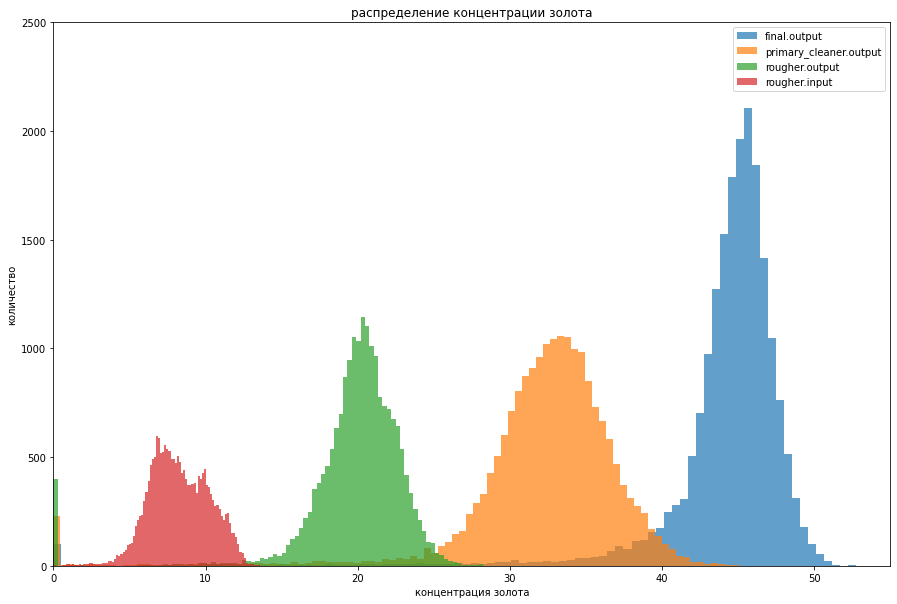

In [18]:
#рисую гистограмму с концентрацией золота

plt.figure(figsize=[15,10])

plt.hist(full['final.output.concentrate_au'], bins=100, label = 'final.output', alpha=.7)
plt.hist(full['primary_cleaner.output.concentrate_au'], bins=100, label = 'primary_cleaner.output', alpha=.7)
plt.hist(full['rougher.output.concentrate_au'], bins=100, label = 'rougher.output', alpha=.7)
plt.hist(full['rougher.input.feed_au'], bins=100, label = 'rougher.input', alpha=.7)

plt.xlim([0, 55])
plt.ylim([0, 2500])

plt.xlabel('концентрация золота')
plt.ylabel('количество')
plt.legend()
plt.title('распределение концентрации золота')

plt.show()

концентрация золота в процессе отфлотации до финальной концентрации увеличивается отчетивыми этапами, есть нулевые значения

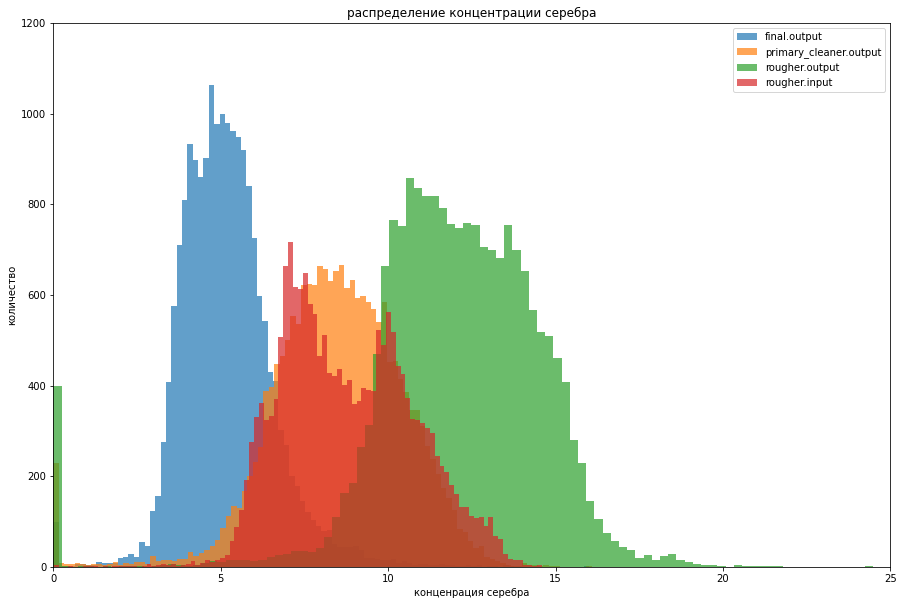

In [19]:
#гистограмма концентрации серебра

plt.figure(figsize=[15,10])

plt.hist(full['final.output.concentrate_ag'], bins=100, label = 'final.output', alpha=.7)
plt.hist(full['primary_cleaner.output.concentrate_ag'], bins=100, label = 'primary_cleaner.output', alpha=.7)
plt.hist(full['rougher.output.concentrate_ag'], bins=100, label = 'rougher.output', alpha=.7)
plt.hist(full['rougher.input.feed_ag'], bins=100, label = 'rougher.input', alpha=.7)

plt.xlim([0, 25])
plt.ylim([0, 1200])

plt.xlabel('конценрация серебра')
plt.ylabel('количество')
plt.legend()
plt.title('распределение концентрации серебра')

plt.show()

возможно ощибка в рассчетах, но концентрация серебра уменьшается в процессе, этапы примерно на четверть заходя друг на друга. концентрация на входе в сырье (rougher.input) и первичной очистке на выходе (primary_cleaner.output) практически совпадают по распределению и количеству
есть нулевые значения

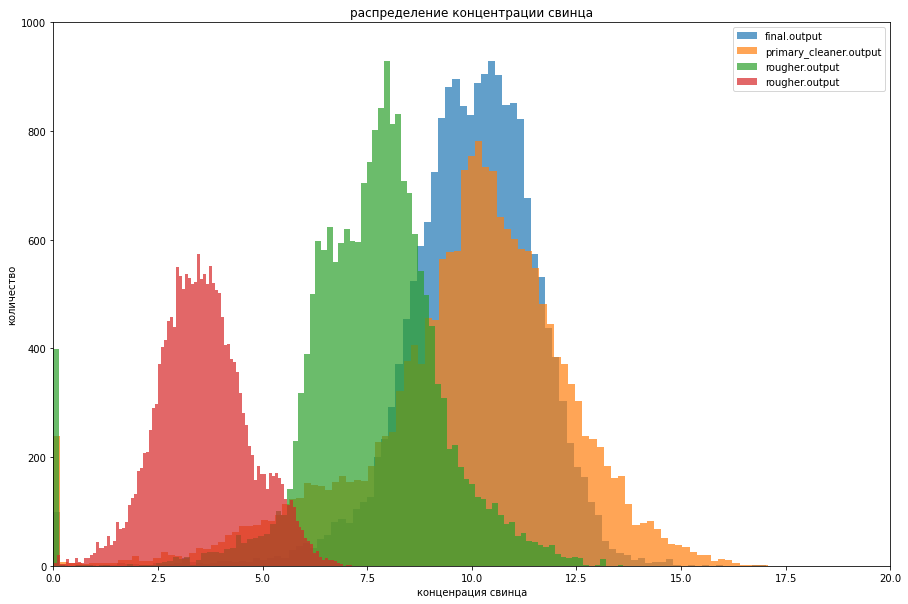

In [20]:
#гистограмма концентрации свинца

plt.figure(figsize=[15,10])

plt.hist(full['final.output.concentrate_pb'], bins=100, label = 'final.output', alpha=.7)
plt.hist(full['primary_cleaner.output.concentrate_pb'], bins=100, label = 'primary_cleaner.output', alpha=.7)
plt.hist(full['rougher.output.concentrate_pb'], bins=100, label = 'rougher.output', alpha=.7)
plt.hist(full['rougher.input.feed_pb'], bins=100, label = 'rougher.output', alpha=.7)

plt.xlim([0, 20])
plt.ylim([0, 1000])

plt.xlabel('конценрация свинца')
plt.ylabel('количество')
plt.legend()
plt.title('распределение концентрации свинца')

plt.show()

распределение этапов в целом не меняется, за исключением концентрация на входе в сырье (rougher.input), на этом этапе логично, что концентрация ниже, чем на дугих этапах , есть значения с нулями

# 2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

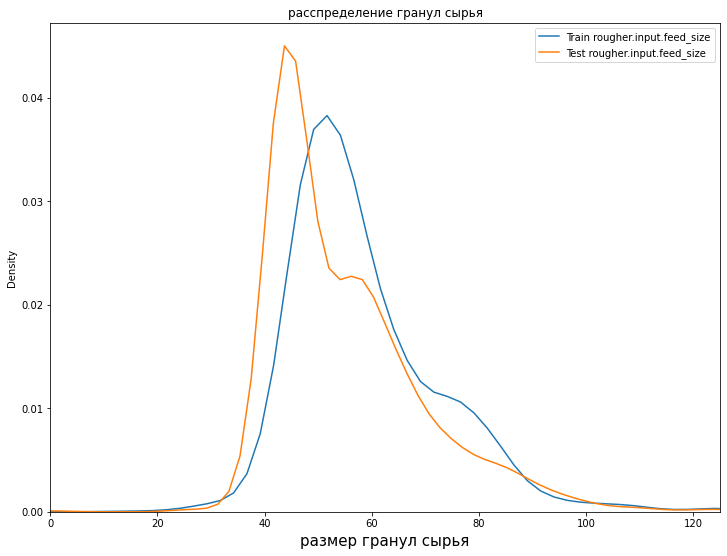

In [43]:
#рисую гистограмму распределения размеров гранул сырья на обучающей и тестовой выборках
#для rougher.input.feed_size

plt.figure(figsize=[12,9])
plt.xlabel('размер гранул сырья', labelpad=5, fontsize=15)

plt.title('расспределение гранул сырья')
plt.xlim([0, 125])

sns.kdeplot(data=train, x='rougher.input.feed_size', label = 'Train rougher.input.feed_size')
sns.kdeplot(data=test, x='rougher.input.feed_size', label = 'Test rougher.input.feed_size')

plt.legend()
plt.show()

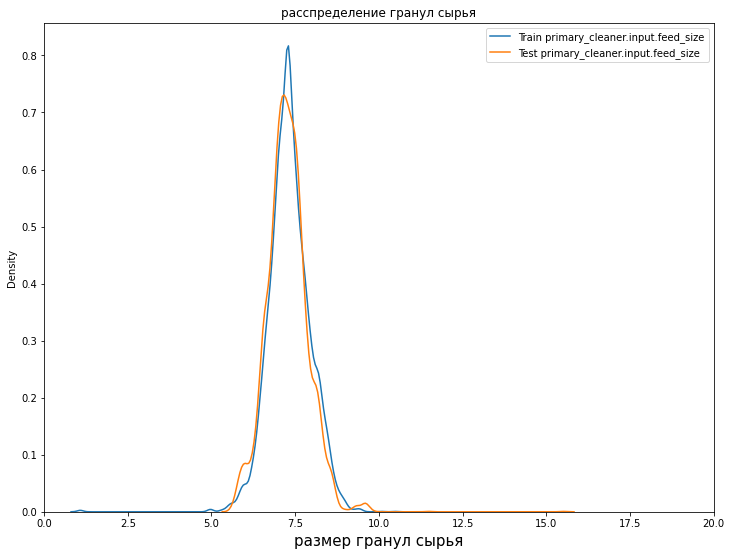

In [45]:
#рисую гистограмму распределения размеров гранул сырья на обучающей и тестовой выборках
#для primary_cleaner.input.feed_size

plt.figure(figsize=[12,9])
plt.xlabel('размер гранул сырья', labelpad=5, fontsize=15)

plt.title('расспределение гранул сырья')
plt.xlim([0, 20])

sns.kdeplot(data=train, x='primary_cleaner.input.feed_size', label = 'Train primary_cleaner.input.feed_size')
sns.kdeplot(data=test, x='primary_cleaner.input.feed_size', label = 'Test primary_cleaner.input.feed_size')

plt.legend()
plt.show()

распределение для флотации и первичной очистки  в обоих выборках практически одинаковое

# 2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [22]:
#считаю суммарные концентрации всех веществ на разных стадиях
#

final_output_concentrate_sum = train[['final.output.concentrate_au', 
                                      'final.output.concentrate_ag', 
                                      'final.output.concentrate_pb', 
                                      'final.output.concentrate_sol']].sum(axis=1) 
final_output_concentrate_sum                                 
                                      

0        63.644396
1        63.957723
2        64.311180
3        63.573449
4        64.004667
           ...    
14144    68.098589
14145    68.274362
14146    68.226068
14147    68.200449
14148    68.353154
Length: 14149, dtype: float64

In [23]:
primary_cleaner_output_concentrate_sum = train[['primary_cleaner.output.concentrate_au', 
                                                'primary_cleaner.output.concentrate_ag', 
                                                'primary_cleaner.output.concentrate_pb',
                                                'primary_cleaner.output.concentrate_sol']].sum(axis=1)
primary_cleaner_output_concentrate_sum

0        72.640924
1        72.543485
2        72.095042
3        59.957723
4        71.321010
           ...    
14144    59.001692
14145    59.703912
14146    59.561096
14147    57.216686
14148    55.748041
Length: 14149, dtype: float64

In [24]:
rougher_output_concentrate_sum = train[['rougher.output.concentrate_au', 
                                        'rougher.output.concentrate_ag', 
                                        'rougher.output.concentrate_pb',
                                        'rougher.output.concentrate_sol']].sum(axis=1)
rougher_output_concentrate_sum

0        66.424950
1        67.012710
2        66.103793
3        65.752751
4        65.908382
           ...    
14144    70.781325
14145    70.539603
14146    55.376330
14147    69.201689
14148    69.544003
Length: 14149, dtype: float64

In [25]:
rougher_input_feed_sum = train[['rougher.input.feed_au', 
                                        'rougher.input.feed_ag', 
                                        'rougher.input.feed_pb',
                                        'rougher.input.feed_sol']].sum(axis=1)
rougher_input_feed_sum

0        51.680034
1        50.659114
2        50.609929
3        51.061546
4        47.859163
           ...    
14144    53.415050
14145    53.696482
14146    54.589604
14147    54.027355
14148    53.535054
Length: 14149, dtype: float64

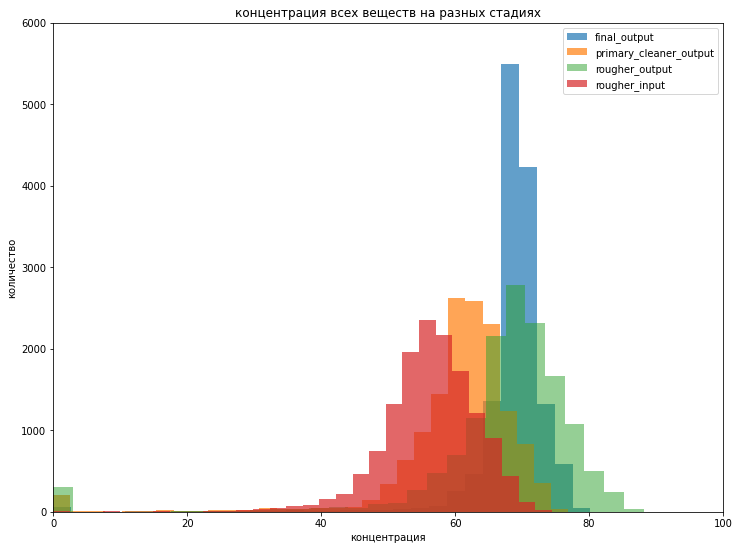

In [26]:
#рисую гистограмму концентрации всех веществ на разных стадиях

plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum, bins=30, label = 'final_output', alpha=.7)
plt.hist(primary_cleaner_output_concentrate_sum, bins=30, label = 'primary_cleaner_output', alpha=.7)
plt.hist(rougher_output_concentrate_sum, bins=30, label = 'rougher_output', alpha=.5)
plt.hist(rougher_input_feed_sum, bins=30, label = 'rougher_input', alpha=.7)

plt.xlim([0, 100])
plt.ylim([0, 6000])

plt.xlabel('концентрация')
plt.ylabel('количество')
plt.legend()
plt.title('концентрация всех веществ на разных стадиях')

plt.show()

есть нулевые значения, на этапе концентраций такого быть не может
концентрация и количество всех веществ на разных стадиях в среднем на 15% к каждому этапу

In [27]:
#по гистограмме видно что нулевых значений не много, но посмотрю сколько конкретно их в каждой сумме концентраций

print(f'final_output = {final_output_concentrate_sum[final_output_concentrate_sum==0].count()}')
print(f'primary_cleaner_output = {primary_cleaner_output_concentrate_sum[primary_cleaner_output_concentrate_sum==0].count()}')
print(f'rougher_output = {rougher_output_concentrate_sum[rougher_output_concentrate_sum==0].count()}')
print(f'rougher_input = {rougher_input_feed_sum[rougher_input_feed_sum==0].count()}')

final_output = 58
primary_cleaner_output = 74
rougher_output = 297
rougher_input = 0


так как это тоько сумма концентраций, удаляю строки с минимальной концентрацией (<1) в исходном train, далее заного посчитаю суммы

In [28]:
#удаляю нули в столбцах с этапом concentrate

for i in train.columns:
    if 'concentrate' in i:
        train = train.drop(train[train[i] < 1].index)

In [29]:
# еще раз считаю сумму концентраций

final_output_concentrate_sum = train[['final.output.concentrate_au', 
                                      'final.output.concentrate_ag', 
                                      'final.output.concentrate_pb', 
                                      'final.output.concentrate_sol']].sum(axis=1) 

rougher_output_concentrate_sum = train[['rougher.output.concentrate_au', 
                                        'rougher.output.concentrate_ag', 
                                        'rougher.output.concentrate_pb',
                                        'rougher.output.concentrate_sol']].sum(axis=1)

primary_cleaner_output_concentrate_sum = train[['primary_cleaner.output.concentrate_au', 
                                                'primary_cleaner.output.concentrate_ag', 
                                                'primary_cleaner.output.concentrate_pb',
                                                'primary_cleaner.output.concentrate_sol']].sum(axis=1)

rougher_input_feed_sum = train[['rougher.input.feed_au', 
                                        'rougher.input.feed_ag', 
                                        'rougher.input.feed_pb',
                                        'rougher.input.feed_sol']].sum(axis=1)


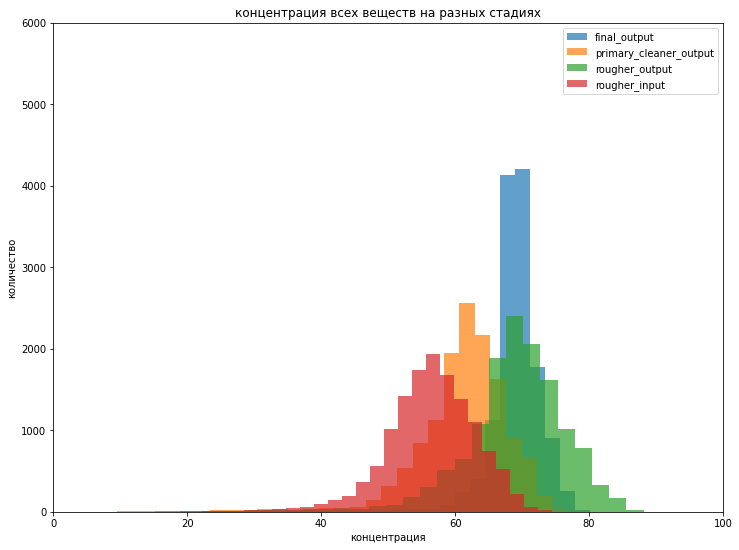

In [30]:
#и рисую гистограмму

plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum, bins=30, label = 'final_output', alpha=.7)
plt.hist(primary_cleaner_output_concentrate_sum, bins=30, label = 'primary_cleaner_output', alpha=.7)
plt.hist(rougher_output_concentrate_sum, bins=30, label = 'rougher_output', alpha=.7)
plt.hist(rougher_input_feed_sum, bins=30, label = 'rougher_input', alpha=.7)

plt.xlim([0, 100])
plt.ylim([0, 6000])

plt.xlabel('концентрация')
plt.ylabel('количество')
plt.legend()
plt.title('концентрация всех веществ на разных стадиях')

plt.show()

распределение смещается не значитеьно от флотации до финальной концентрации, количество финальной концентрации почти в два раза выше

вывод:
    1. изучены концентрации всех веществ на разных стадях
    2. размер гранул на тренировочной и тестовой выборках
    3. сумарная концентрация вечещств, в большнстве случавем концентрация увеличивается от начальных до финальных этапов
    4. удалены аномальные данные с концентрацией <1
   

## Модель

In [31]:
#удаляю стобцы в train, котрых нет в test и сразу проверяю

train = train[test.columns]
print(train.shape)
print(train.columns)

(13415, 54)
Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.s

In [32]:
#удаляю таргетные стоблцы из train для подготовки features

features_train = train.drop('rougher.output.recovery', axis=1)
features_train = features_train.drop(['final.output.recovery'], axis=1)

target_train = train[['rougher.output.recovery', 'final.output.recovery']]
target_train
#Предсказать нужно будет не только rougher.output.recovery, но и final.output.recovery

,rougher.output.recovery,final.output.recovery
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016
...,...,...
14144,89.574376,73.755150
14145,87.724007,69.049291
14146,88.890579,67.002189
14147,89.858126,65.523246


In [33]:
#оставляю таргетные столбцы в train для подготовки target

target_train = train[['rougher.output.recovery', 'final.output.recovery']]
target_train

,rougher.output.recovery,final.output.recovery
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016
...,...,...
14144,89.574376,73.755150
14145,87.724007,69.049291
14146,88.890579,67.002189
14147,89.858126,65.523246


In [34]:
#аналогично для test

features_test = test.drop('rougher.output.recovery', axis=1)
features_test = features_test.drop(['final.output.recovery'], axis=1)

target_test = test[['rougher.output.recovery', 'final.output.recovery']]

In [35]:
#функция для вычисления итоговой sMAPE.

def sMAPE_score(target, target_pred):
   
    return ((1/len(target)) * np.sum(2 * np.abs(target - target_pred) / 
                                       (np.abs(target) + np.abs(target_pred)))) * 100
    
def sMAPE_final_score(target, target_pred):
    target_r = target['rougher.output.recovery']
    target_f = target['final.output.recovery']
    
    target_pred_r = target_pred[:, 0]
    target_pred_f = target_pred[:, 1]
    
    return 0.25 * sMAPE_score(target_r, target_pred_r) + 0.75 * sMAPE_score(target_r, target_pred_r)
        
        
sMAPE_scorer = make_scorer(sMAPE_final_score, greater_is_better=False)

In [36]:
# линейная регрессия

model = LinearRegression()
model.fit(features_train, target_train)
sMAPE = cross_val_score(model, features_train, target_train, cv=3, scoring=sMAPE_scorer, 
                        n_jobs=-1, verbose=10).mean()
print(f'Лучшее значение sMAPE для линейной регрессии:{-sMAPE}')

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................... score: (test=-9.300) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-9.564) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END .............................. score: (test=-13.028) total time=   0.4s
Лучшее значение sMAPE для линейной регрессии:10.630805220920166


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


In [37]:
#Случайный лес


param_grid = {'n_estimators': range(10, 100, 10), 'max_depth': range(1, 10)}
 
model = RandomForestRegressor(max_depth=2, random_state=state)
GSCV = GridSearchCV(model, param_grid, cv=5, scoring=sMAPE_scorer, n_jobs=-1, verbose=10)
GSCV.fit(features_train, target_train)
    
print(f'лучшее значение sMAPE для случайного леса: {-GSCV.best_score_}') 
print(f'при значениях гиперпараметров: {GSCV.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=1, n_estimators=10................................
[CV 1/5; 1/4] END ..............max_depth=1, n_estimators=10; total time=   0.6s
[CV 2/5; 1/4] START max_depth=1, n_estimators=10................................
[CV 2/5; 1/4] END ..............max_depth=1, n_estimators=10; total time=   0.5s
[CV 3/5; 1/4] START max_depth=1, n_estimators=10................................
[CV 3/5; 1/4] END ..............max_depth=1, n_estimators=10; total time=   0.5s
[CV 4/5; 1/4] START max_depth=1, n_estimators=10................................
[CV 4/5; 1/4] END ..............max_depth=1, n_estimators=10; total time=   0.5s
[CV 5/5; 1/4] START max_depth=1, n_estimators=10................................
[CV 5/5; 1/4] END ..............max_depth=1, n_estimators=10; total time=   0.5s
[CV 1/5; 2/4] START max_depth=1, n_estimators=20................................
[CV 1/5; 2/4] END ..............max_depth=1, n_es

In [38]:
#Дерево Решений

param_grid = {'max_depth': range(1, 10)}

model = DecisionTreeRegressor(random_state=state)
GSCV = GridSearchCV(model, param_grid, cv=5, scoring=sMAPE_scorer)
GSCV.fit(features_train, target_train)

print(f'лучшее значение sMAPE для дерева решений: {-GSCV.best_score_}')
print(f'при значениях гиперпараметров: {GSCV.best_params_}')     

лучшее значение sMAPE для дерева решений: 7.048391587278987
при значениях гиперпараметров: {'max_depth': 1}


вывод: лучшая модель случайный лес с sMAPE = 6.6, при значениях гиперпараметров: {'max_depth': 3, 'n_estimators': 10}, на ней и буду проводить итоговое тестирование

In [41]:
#тестирование лучшей модели

model = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=state) 
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

print('sMAPE для тестовых данных:', sMAPE_final_score(target_test, predictions_test))

sMAPE для тестовых данных: 8.724442937192423


In [42]:
#константная модель


#target_train_r = target_train['rougher.output.recovery']
#target_train_f = target_train['final.output.recovery']

#target_test_r = target_test['rougher.output.recovery']
#target_test_f = target_test['final.output.recovery']


model = DummyRegressor(strategy='mean')
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

print('sMAPE для тестовых данных:', sMAPE_final_score(target_test, predictions_test))




sMAPE для тестовых данных: 8.973014215038752


вывод:
случайный лес дал лучшее значение sMAPE = 6.60
на тестовой выборке случайный лес предсказал значения целевых признаков rougher.output.recovery и final.output.recovery с sMAPE = 8.7


итоговый вывод:
    1. изучены и обработаны данные
    2. проведен анализ концентрации, размера гранул, исследована суммарная концентрация
    3. построены и обучены 3 модели, с выбором лучших гиперпараметров через автоматическое подбирания параметров GridSearchCV
    4. выбрана лучшая модель Случайный лес с симметричной средней абсолютной процентной ошибкой sMAPE  = 6.6
    5. проверил Случайный лес на тестовых данныхс sMAPE = 8.7
    6. подтвердил оценку через  константную модель с sMAPE = 8.9
